*Hey, are you using VSCode for this notebook?* 
If you are, you may notice some problems with the tqdm progress bars. If it becomes a big problem for you, like I found it to be, check out this version which fixes that bug:

[https://pypi.org/project/vscode-tqdm/](https://pypi.org/project/vscode-tqdm/)

# Examples from the choice tree

This notebook tries to cover every possible choice in the DEFIANT choice tree shown below

![image](../defiant_OS_choice_tree.png)

This choice tree is a fairly large, and if you'd rather, you can use the function ``what_kind_of_OS_are_you()`` found in:

```defiant.extra.fun.what_kind_of_OS_are_you()``` 

which asks you questions about the analysis you may want to run given your situations. Be aware that this function will **always** suggest using pair covariance, despite your decisions. This is largely thanks to the increased parameter estimation capability. However, if you plan to get signal-to-noise ratios, then you should set ``pair_covariance=False`` as calibrating the SNR is far simpler without pair covariance

## What is in this notebook?

This notebook *breifly* shows you how to use DEFIANT for every single branch of the choice tree. As such, this is an exceptionally long notebook and I suggest that you scroll to the branch you wish to use in your analysis. The dataset being used in this notebook is the Mock-Data-Challenge 1 (MDC1) which consists of 36 pulsars with no red noise, toa uncertainty all set at 0.1 microseconds with EFAC set to 1, and no red noise.

Included with DEFIANT is a handy module which can import these pulsars for you and make an enterprise PTA object designed to model these simulations. In addition, DEFIANT also provides ways in which you can create your own simulations using these 36 pulsars as a base. All of these can be found within:
```defiant.extra.mdc1_utils```



## Imports and loading data

If you have not installed DEFIANT through pip, you can use the following cell to import without installation

In [1]:
import sys
sys.path.insert(0,'../') # Add the defiant directory to the python path

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from la_forge.core import Core
from enterprise.signals.utils import powerlaw

from defiant import OptimalStatistic
from defiant import utils, orf_functions
from defiant import plotting as defplot

from defiant.extra import mdc1_utils

#### Next, we need to load up the pulsars, make a PTA object, and load in the CURN core

``mdc1_utils`` makes most of this trivial. The common uncorrrelated red-noise (CURN) search la_forge.core.Core object for the MDC1 pulsars has been included with DEFIANT, but can be run on your own if you would like. 

A couple of notes:
- It is best practice to use **EXACTLY** the same PTA object for OS analysis as was used for MCMC sampling. There may be cases when this isn't true, but if that should only happen when you know exactly what you are doing.
- The returned injected values (``inj_params`` in this case) is in the correct format to give to the enterprise PTA object.
- Know that ``create_MDC1_PTA()`` also works with simulated pulsars generated with ``create_MDC1_like_psrs()``
- DEFIANT works well with the marginalizing timing model that often used to speed up the MCMC process. This was previously not true for the enterprise_extensions version.


In [3]:
# Returns both the list of pulsars and the injected parameters
psrs,inj_params = mdc1_utils.get_MDC1_psrs() 
# Create the PTA based on the pulsars loaded
pta = mdc1_utils.create_MDC1_PTA(psrs, gwb_components=10, gwb_name='gw') 


# For future plots, we will want the injected spectrum too
fgw = utils.get_pta_frequencies(pta, gwb_name='gw')
inj_spectrum = powerlaw(fgw, inj_params['gw_log10_A'], inj_params['gw_gamma'], 1)


# Load in the core object
lfcore = Core(corepath='./MDC1_FG_CURN_samples.core')

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
Loading data from HDF5 file....


#### If you want to make your own core...

Use the following cell with ``to_sample=True`` to create your own core. You will need to sample the PTA object to find estimates for all red-noise parameters

In [4]:
to_sample = False

if to_sample:
    from enterprise_extensions.sampler import setup_sampler

    chain_loc = 'MDC1_FG_CURN_samples/'

    # Use enterprise_extensions setup_sampler to speed up the process!
    sampler = setup_sampler(pta, chain_loc, resume=True, human='KAG')

    x0 = np.hstack(p.sample() for p in pta.params) # Get an initial sample

    sampler.sample(x0, Niter=int(1e6)) # Run a million samples

    lfcore = Core(chaindir=chain_loc)

    lfcore.save('MDC1_FG_CURN_samples.core')

## Creating the Optimal Statistic object

DEFIANT tries to be as similar to the enterprise_extensions.frequentist.optimal_statistic as reasonable to make the transition as simple as possible. However, there are several important changes to note.

The first and most important is that DEFIANT's OptimalStatistic object now supports any PTA object as long as the the GWB components have keys like ``gwb_name+'_log10_A'`` or ``gwb_name+'_log10_rho_0'`` (DEFIANT requires at least one of these two keys in the PTA to work. If your PTA model doesn't include these but you think it should still work, raise an issue on Github). This now includes free-spectral models as well! Do note that ENTERPRISE may throw errors if you do not set the ``gwb_name`` parameter properly. 

The second important change is the ability to feed the OS object a la_forge.Core object for easy noise marginalization. These core objects are not required, but highly suggested as without it, you will need to manually tell DEFIANT which parameters to compute the OS with. There are many ways in which you can supply a la_forge.core.Core object. Firstly, you do not need to supply a core on instantiation, instead you can use ``OS_obj.set_chain_params()`` to do this after creation. However, for ease of use, you can set these parameters at the time of creation as well.

In general there are 5 ways to add parameter samples to the DEFIANT OptimalStatistic object. The following is a full list of potential ways to supply these in order of most preferred to least:
1. core 
    - Supplying the la_forge.core.Core object directly
2. corepath 
    - Supplying the path to a saved la_forge.core.Core object
3. chain_path 
    - A path to a PTMCMC chain directory including pars.txt
4. chain & param_names 
    - An np.ndarray chain of parameter values and the corresponding list of names 
5. chain 
    - An np.ndarray chain of parameter values which will be assumed to be in the same order as the pta object supplied

Once supplied, the core gets added as an attribute to the OptimalStatistic object through the ``.lfcore`` attribute

Next, you may wish to set an overlap reduction function (ORF) at the time of object creation. This can be done by setting the ``orf``, ``orf_names``, and ``pcmc_orf`` parameters. The details of which can be found in the function which can set these after the instantiation, ``OS_obj.set_orf()``. The gist is that you can either supply a single ORF for single component optimal statistic or a list of ORFs for a multi-component optimal statistic (MCOS). The pre-defined ORFs are:
- 'hd' or 'hellingsdowns': Hellings and Downs
- 'dp' or 'dipole': Dipole
- 'mp' or 'monopole': Monopole
- 'gwdp' or 'gw_dipole': Gravitational wave dipole
- 'gwmp' or 'gw_monopole': Gravitational wave monopole
- 'st' or 'scalar_tensor': Scalar tensor
- 'l_' or 'legendre_': Legendre polynomials where the number after the _ is the degree

(These may not be updated, check defiant.orf_functions.defined_orfs for the most up-to-date pre-defined orfs)

In [5]:
# Since we created our PTA object with 'gw' as the name, make sure to set that!
OS_obj = OptimalStatistic(psrs, pta=pta, gwb_name='gw', core=lfcore, orfs=['hd'])

``orf_names`` is optional and will default to the names of the functions if left as None. The ``pcmc_os`` argument is a feature to enforce a particular ORF for the pair covariance matrix if used with multiple ORF components. This is only imporant if using both multi-component and pair covariance at the same time. If set to None, DEFIANT will use a non-pair covariant OS to find the estimated correlated power to use in the pair covariance matrix calculation. This parameter helps a lot in some specific cases where powers in individual ORFs are very low or negative. In general, its good to set this to 'hd', generating the pair covariance matrix assuming strictly Hellings and Downs correlations.

### Custom ORFs

DEFIANT also supports user-made ORFs! These can be especially helpful if the model you wish to search for has a non-standard, or seldom used ORF. Importantly, custom ORF functions should take in two [``enterprise.BasePulsar``](https://github.com/nanograv/enterprise/blob/master/enterprise/pulsar.py#L70C7-L70C17) objects and the output should be a float corresponding to the ORF between those two pulsars. The reasoning behind abstracting into two pulsars was to allow for ORFs which are anisotropic or dependent on other pulsar parameters. 

If you want to make your own ORF, look into ``defiant.orf_functions.py`` for examples and implement your own using the following skeleton: 

In [6]:
################################################################################
#                       Creating your own ORF functions
#
# If you plan to make your own overlap reduction functions, you can use these
# functions as a template. Note that while the functions here are mostly vectorized,
# DEFIANT will not use vectorization for the ORF functions. The vectorization is
# done purely for the convenience of the user wanting to use the functions directly.
# Additionally, while the functions here allow for both inputs of enterprise.Pulsar
# objects and pulsar separations, DEFIANT will only call the orf functions with
# two enterprise.Pulsar objects. 
#
# This means that the minimum requirement for an ORF function is to take two
# enterprise.Pulsar objects as input and return a float.
# 
# Here is an example template which you can copy and modify:

def orf_template(psr1, psr2):
    """A simple template for creating your own ORF functions

    This is a simple template for creating your own ORF functions. The function
    will take two enterprise.Pulsar objects as input and return a float.

    Args:
        psr1 (enterprise.Pulsar): The first pulsar object
        psr2 (enterprise.Pulsar): The second pulsar object

    Returns:
        float: The ORF value
    """
    # It is also a good habit to include a check for the same pulsar. Technically,
    # DEFIANT should not supply two of the same pulsar, but this is still good practice.
    if psr1.name == psr2.name:
        return 1

    # If you have a custom isotropic ORF function, you can use the get_pulsar_separation
    # function to get the separation between the two pulsars. Anisotropic ORF functions
    # will may need specific pulsars properties to calculate the ORF value, hence the
    # need for the enterprise.Pulsar objects.
    xi = orf_functions.get_pulsar_separation(psr1, psr2)


    # Perform some calculations to get the ORF value. In this case, lets just return
    # the cosine of the separation. (A dipole ORF function)
    ret = np.cos(xi)

    return ret
################################################################################

After you've defined your function, you can add it to the OS_obj through the ``OS_obj.set_orf()`` function

In [7]:
OS_obj.set_orf([orf_template],['dipole'])

### Helpful plotting

As an asside, DEFIANT has many quality of life feautres including easy access to all of the pre-defined ORF functions. In particular the ``defiant.orf_functions.get_orf_function()`` is an extremely useful function it can give you the ORF model you used easily. 

Note that for ALL pre-defined ORFs that are isotropic, the orf_functions support both supplying pairs of pulsars as well as pulsar separation angles. When supplying pulsar separation angles, these functions are vectorized too! These can be very convenient for plotting!

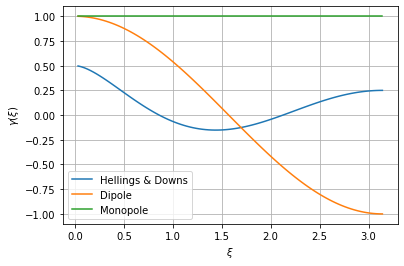

In [8]:
xi_range = np.linspace(0,np.pi,100)[1:] # Define our range of pulsar separations

# These function calls return the ORF functions, which can be given either pairs
# of enterprise.Pulsar objects or pulsar separations (which is vectorized).
hd_orf = orf_functions.get_orf_function('hd') 
dp_orf = orf_functions.get_orf_function('dp')
mp_orf = orf_functions.get_orf_function('mp')


# Turn these into an actual model of correlations
hd_mod = hd_orf(xi_range)
dp_mod = dp_orf(xi_range)
mp_mod = mp_orf(xi_range)

# Plot the ORF functions
plt.plot(xi_range, hd_mod, label='Hellings & Downs')
plt.plot(xi_range, dp_mod, label='Dipole')
plt.plot(xi_range, mp_mod, label='Monopole')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\gamma(\xi)$')
plt.legend()
plt.grid()
plt.show()

# Case 1: OS
Equivalent to enterprise_extensions.frequentist.optimal_statistic

Note that this also returns the covariance matrix C, however, since we are not using pair covariance, it will be only the diagonal elements sig^2. You also have the option to not return the pair values (xi,rho,sig,C). This can be helpful when you don't care about these intermediate data products and only need estimated amplitude and uncertainty (A2,A2s)

Note that compute_OS can either be run with a specific dictionary of parameters (i.e. ``params=inj_params`` supplies the injected parameters) or it can be left as ``params=None``, in which case the parameter values used will be the maximum likelihood ones found in the la_forge.core.Core object supplied.

Also Note that the ``params`` will only be used if ``N=1``.

In [9]:
# Set our ORF to HD
OS_obj.set_orf(['hd'])

# If params=None, then DEFIANT will use maximum likelihood values from OS_obj.lfcore
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(params=inj_params)


Now plot. We can do this using some of DEFIANT's built in plotting tools. Here, lets plot the pair correlations.

You may also want to use ``defiant.utils.binned_pair_correlations()`` if you want to make these plots yourself.

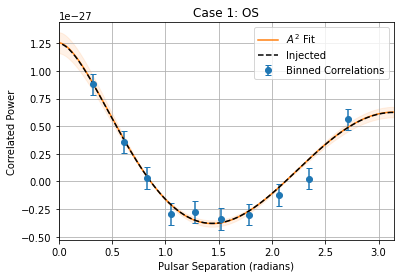

In [10]:
# Plot the binned pair correlation plot. 
defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s, bins=10,)
plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.title('Case 1: OS')
plt.legend()
plt.show()

# Case 2: NM+OS

Adding in noise marginalization is easy with DEFIANT has the OS_obj already contains the chain to be marginalized! Here, lets use ``return_pair_vals=False`` to ignore the intermediate data products.

Also note that when using noise marginalization (indicated to DEFIANT by setting ``N>1``), the returns will include the chain idices as well. This can be very helpful for diagnosing strange individual parameter vectors within the chain. Unless something goes wrong, or you want to reproduce the result, the ``idx`` term can safely be ignored. 

Since the returned ``A2`` values are only the means of each distribution, plotting those individually while ignoring the uncertainties on those values is a poor idea. Instead you should use **uncertainty sampling**. This replaces each mean datapoint with a corresponding sampling of gaussian centered on the point with standard deviation dictated by A2s. DEFIANT has a function to do this process for you! 

```defiant.utils.uncertainty_sample()```

In [11]:
OS_obj.set_orf(['hd'])

# When N>1, params is ignored. The default value of params is None, so we are good!
A2,A2s,idx = OS_obj.compute_OS(N=1000, return_pair_vals=False)


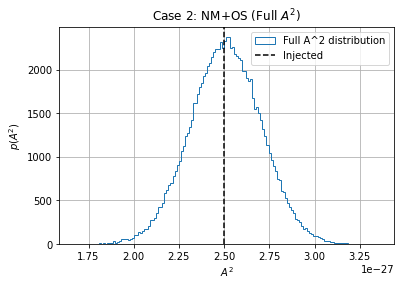

In [12]:
full_A2 = utils.uncertainty_sample(A2,A2s,pfos=False,mcos=False)
plt.hist(full_A2,bins='auto',histtype='step',label='Full A^2 distribution')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='k',label='Injected')

plt.title('Case 2: NM+OS (Full $A^2$)')
plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Case 3: PC+OS

Adding in pair covariance is easy! Simply set the flag to true: ``pair_covariance=True``

Pair covariance does take signficiantly more time, but it used to take minutes to calculate. Seconds is much more reasonable.


When plotting with ``defiant.plotting.create_correlation_plot``, pair covariance will be taken into acount when making the individual bins. 

In [13]:
OS_obj.set_orf(['hd'])

xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params, pair_covariance=True)


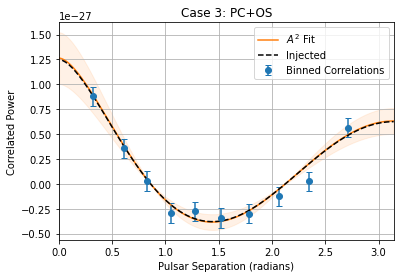

In [14]:
# Plot the binned pair correlation plot. 
defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s, bins=10,)
plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.title('Case 3: PC+OS')
plt.legend()
plt.show()

# Case 4: PC+NM+OS

Now we start to increase the computational demand. Pair covariance increases the time for each noise marginalized iteration by several orders of magnitude. With more pulsars, be prepared to wait.

In [15]:
OS_obj.set_orf(['hd'])

A2,A2s,idx = OS_obj.compute_OS(N=100, pair_covariance=True, return_pair_vals=False)


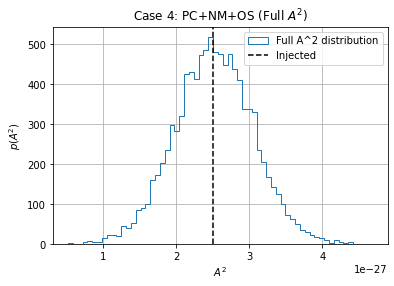

In [16]:
plt.title('Case 4: PC+NM+OS (Full $A^2$)')
full_A2 = utils.uncertainty_sample(A2,A2s,pfos=False,mcos=False)
plt.hist(full_A2,bins='auto',histtype='step',label='Full A^2 distribution')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='k',label='Injected')

plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Case 5: narrowband PF+OS

The narrowband-normalized PFOS is a unique analysis that you probably don't need to use. It is similar to the radiometer anisotropic search in that it assumes no power in frequencies other than the one being analyzed. While this can work in cases with narrowband power or a weak-signal GWB, it becomes more biased at higher signal regimes. Unless these attributes are desirable, use the broadband-normalized PFOS instead [Case 9]. 

With the PFOS, we now can make 2 different types of plots, one being the spectrum, and the other being the correlation plot for each frequency.

In [17]:
OS_obj.set_orf(['hd'])

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, narrowband=True)

fgw = OS_obj.freqs

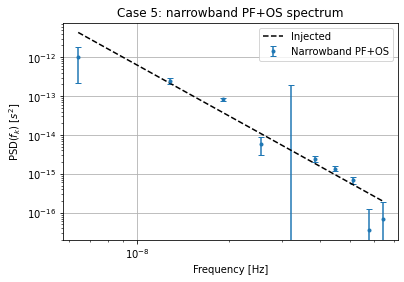

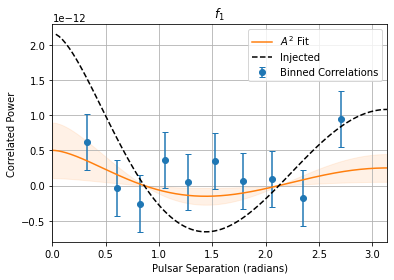

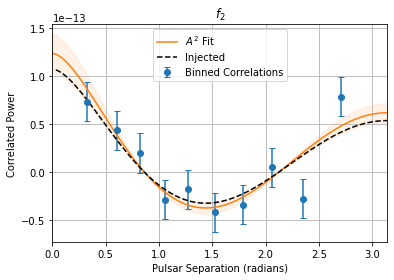

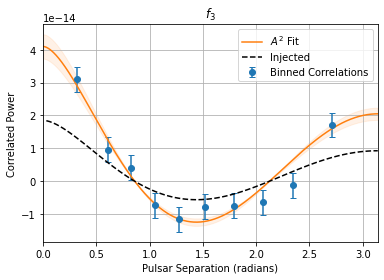

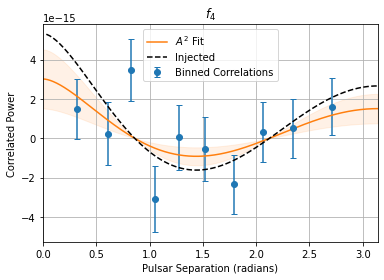

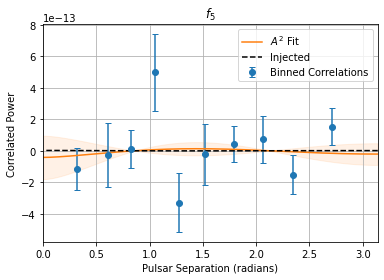

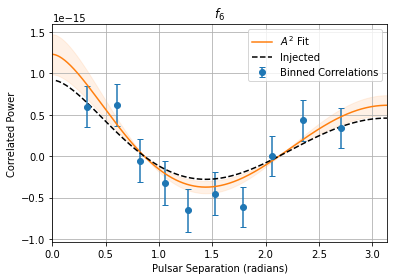

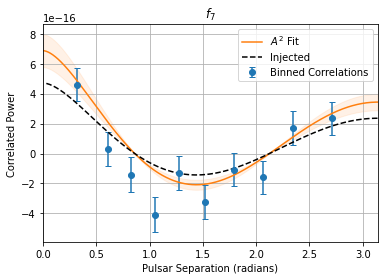

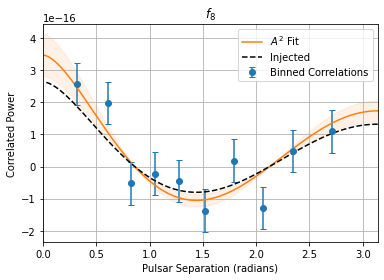

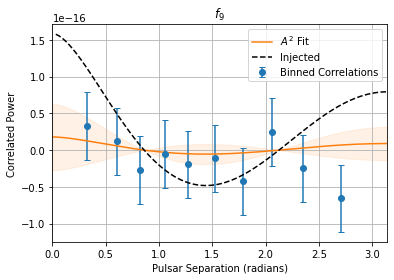

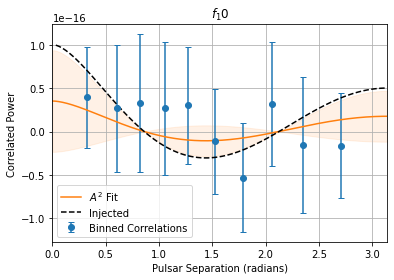

In [18]:
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Narrowband PF+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 5: narrowband PF+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()


for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')
    
    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()
plt.show()

# Case 6: narrowband PF+NM+OS

Adding in noise marginalization to the mix. This time, when we do uncertainty sampling, we get the spread of the PSD at each frequency. If we want to directly compare the noise marginalization total uncertainty with the non-noise marginalized, we can use uncertainty sampling, then take the means and standard deviations.

In [19]:
OS_obj.set_orf(['hd'])

Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, return_pair_vals=False, narrowband=True)

fgw = OS_obj.freqs

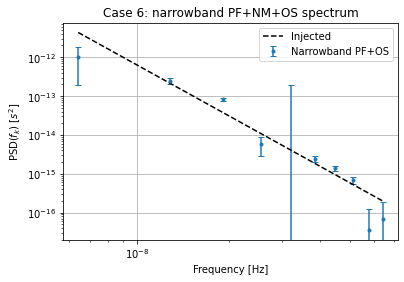

In [20]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=False)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean,Sk_std,fmt='.',capsize=3,label='Narrowband PF+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')


plt.title('Case 6: narrowband PF+NM+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()


# Case 7: narrowband PF+PC+OS

Adding in pair covariance. Note that pair covariance with per-frequency can be pretty slow

In [21]:
OS_obj.set_orf(['hd'])

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, pair_covariance=True,
                                             narrowband=True)

fgw = OS_obj.freqs

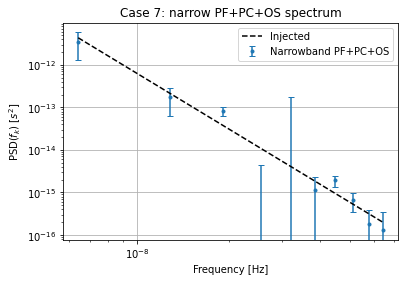

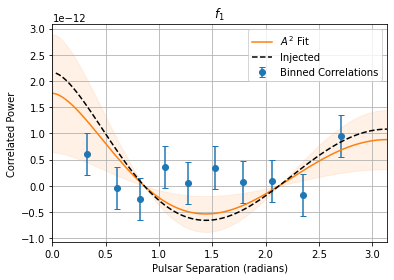

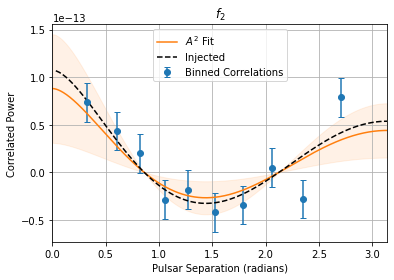

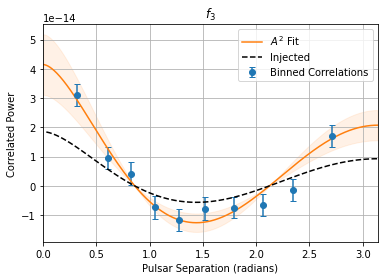

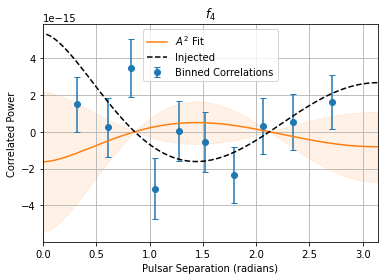

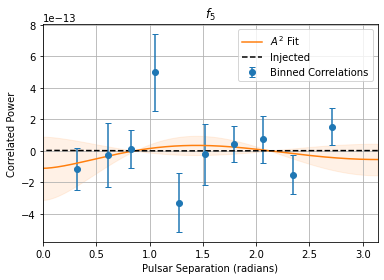

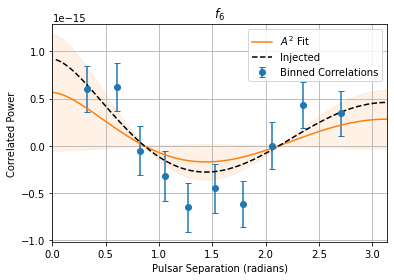

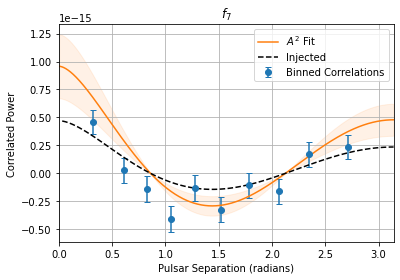

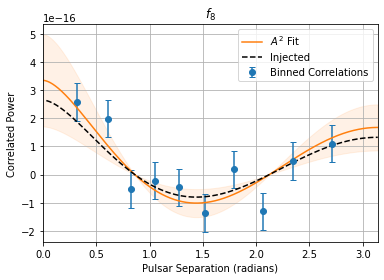

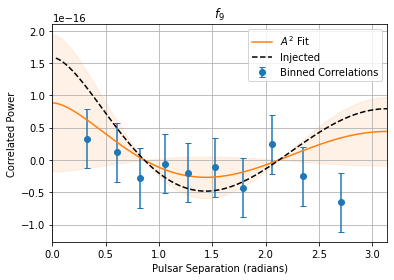

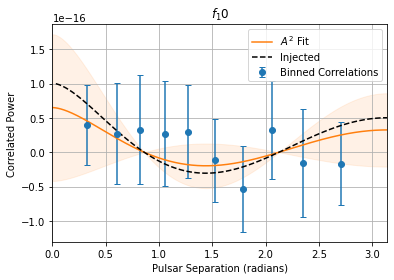

In [22]:
plt.title('Case 7: narrow PF+PC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Narrowband PF+PC+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')


plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 8: narrowband PF+PC+NM+OS

This one may take a while. Combining iteration per frequency and with noise marginalization on top of the relatively slow speed of pair covariance can make this take a ton of time. BUT, its still many orders of magnitude faster than Bayesian!

In [23]:
OS_obj.set_orf(['hd'])

Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False, narrowband=True)

fgw = OS_obj.freqs

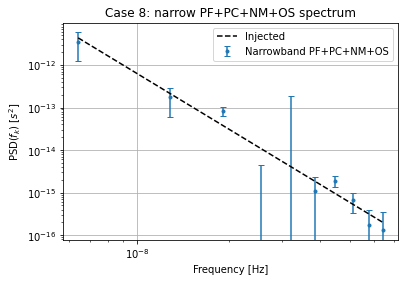

In [24]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=False)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean,Sk_std,fmt='.',capsize=3,label='Narrowband PF+PC+NM+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 8: narrow PF+PC+NM+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

# Case 9: PF+OS

The (broadband-normalized) Per-Frequency OS is usually the better option than using the narrowband-normalized PFOS. It accounts for GWB power in all frequencies while estimating, leading to better overall estimates in a wider range of scenarios. 

While it may seem like there are only upsides to the PFOS, there is one major one which is its poor performance when using a free-spectral CURN model. For rather complicated reasons, the large differences between high frequency spectral estimates due to white noise limitations cause poor overall estimation at all frequencies. For these reasons, its best to stick with a power-law CURN model and let the PFOS find the power-law deviations.

In [25]:
OS_obj.set_orf(['hd'])

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params)

fgw = OS_obj.freqs

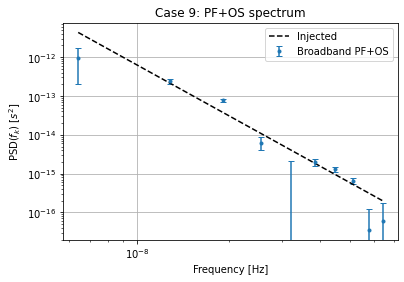

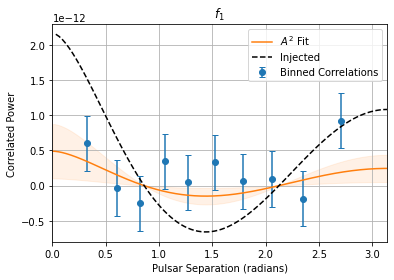

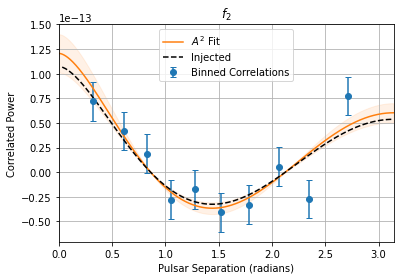

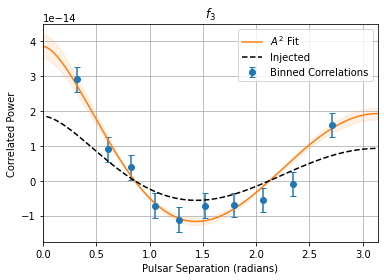

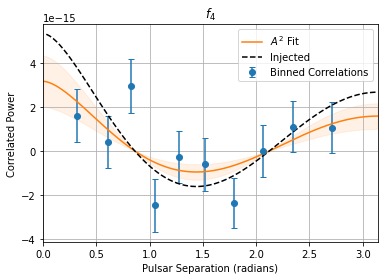

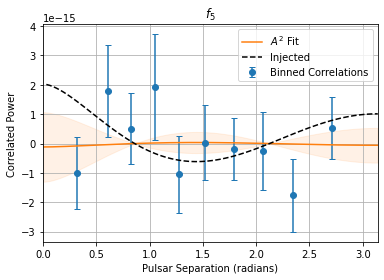

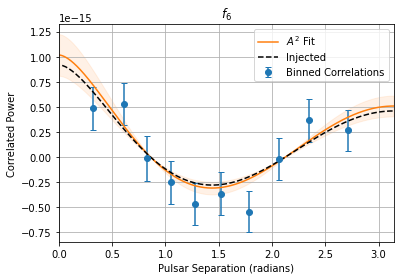

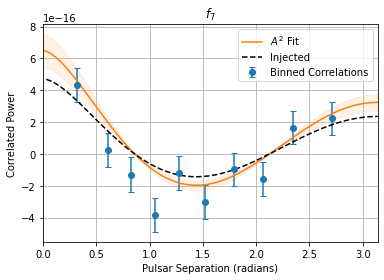

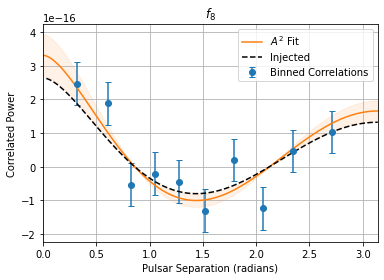

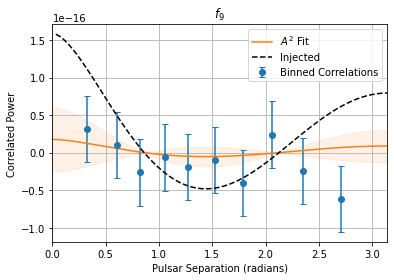

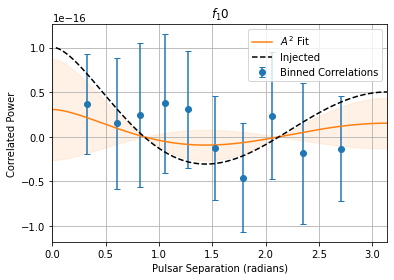

In [26]:
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Broadband PF+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.title('Case 9: PF+OS spectrum')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 10: PF+NM+OS

In [27]:
OS_obj.set_orf(['hd'])

Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, return_pair_vals=False)

fgw = OS_obj.freqs

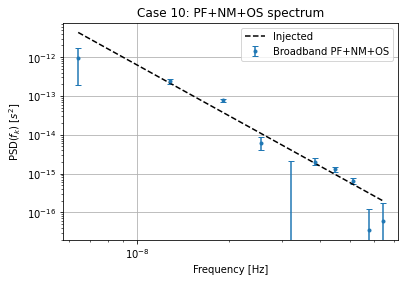

In [28]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=False)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean,Sk_std,fmt='.',capsize=3,label='Broadband PF+NM+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 10: PF+NM+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

# Case 11: PF+PC+OS

In [29]:
OS_obj.set_orf(['hd'])

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, pair_covariance=True)

fgw = OS_obj.freqs


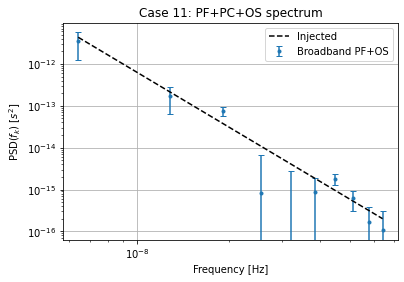

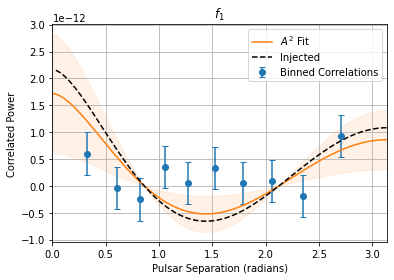

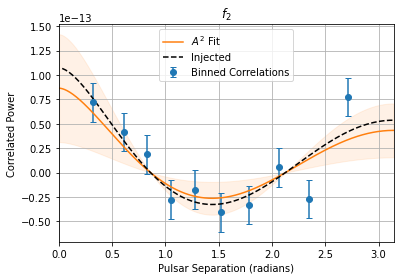

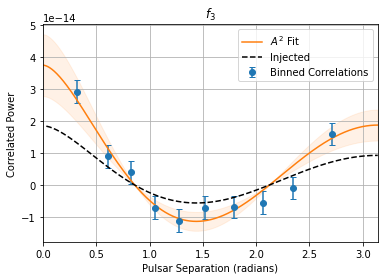

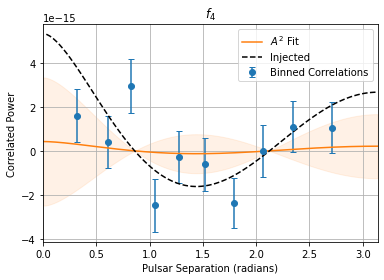

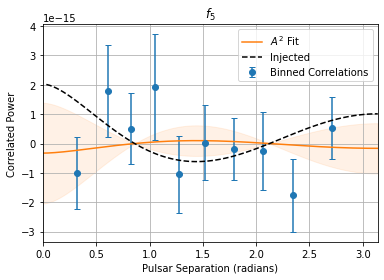

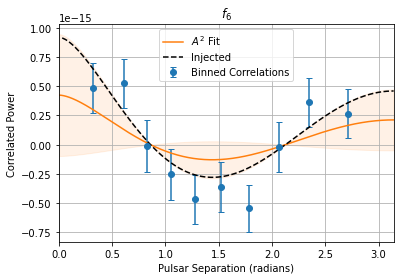

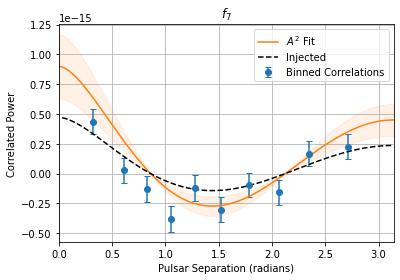

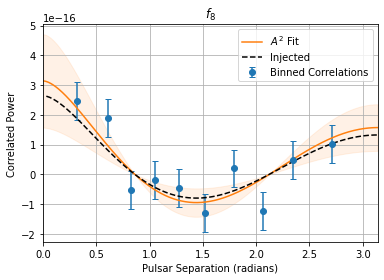

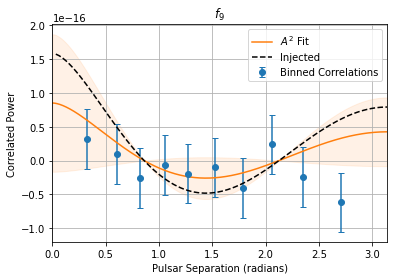

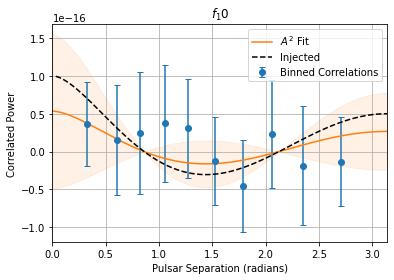

In [30]:
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Broadband PF+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 11: PF+PC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10,orf=OS_obj.orf_names)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 12: PF+PC+NM+OS

And this is the longest calculation that DEFIANT needs to calculate. For every noise marginalized iteration, we need to calculate the pair covariance matrix for each frequency. This can take anywhere from 10 minutes with small datasets upwards to 40 minutes with NG15 data. There are many optimizations left to do for this, so this number may still be reduced significantly in the future.

In [31]:
OS_obj.set_orf(['hd'])

Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False)

fgw = OS_obj.freqs


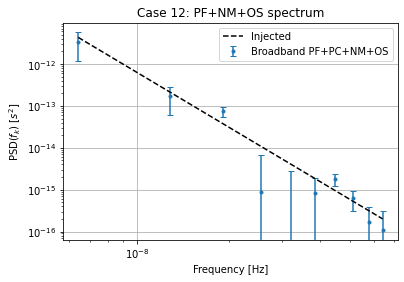

In [32]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=False)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean,Sk_std,fmt='.',capsize=3,label='Broadband PF+PC+NM+OS')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 12: PF+NM+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

# Case 13: MC+OS

Coming now to the MCOS and its combinations, there is a couple of things to note and a huge caveat to consider:

**Note**:

When using the MCOS, the returned value ``A2s`` or the per frequency equivalent ``Sks`` are now not single values, but rather the covariance matrix between each component. You can approximate each individual component's standard deviation by taking the square root of the diagonal element corresponding to that component. 


**Caveat**

If you plan on using the multiple-component OS in combination with pair covariance (with or without using per-frequency), there are two options for how to go about this calculation. Since the pair covariance matrix needs an estimate of the total correlated power DEFIANT can either:

1. Estimate the total correlated power by using a non-pair covaiant MCOS fit first, then use the resulting power distribution in a dot product with the correlation per component.

OR

2. Use a particular ORF as a 'close enough' estimate and forgo the non-pair covariant fit.

While this may seem like 1 is an easy choice, this is not the case much of the time. The heart of this problem comes from scenarios in which one or more ORFs are small or unconstrained. This can cause the resulting total correlated power to fluctuate far more than would be expected. This then results in a poor estimation of each of the components. To get around this problem, you can use an 'approximate' ORF by setting the flag for the ``pcmc_orf`` to your expected ORF (i.e. probably ``'hd'``). This can be especially useful with ORFs like dipole where most, if not all, dipole is far too small to measure meaningfully.

For all of our tests we will be setting ``pcmc_orf='hd'``, although this won't do anything unless using both multi-component and pair covariant.


In [33]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params)


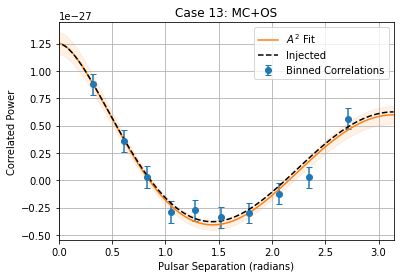

In [34]:
defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s,bins=10,orf=OS_obj.orf_names)

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.title('Case 13: MC+OS')
plt.legend()
plt.show()

# Case 14: NM+MC+OS


In [35]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

A2,A2s,idx = OS_obj.compute_OS(N=1000, return_pair_vals=False)

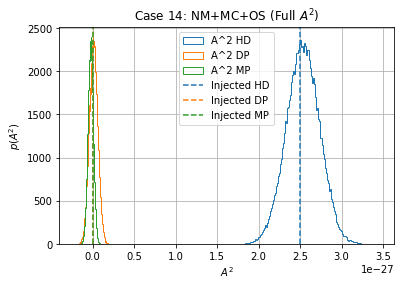

In [36]:
full_A2 = utils.uncertainty_sample(A2,A2s,pfos=False,mcos=True)

plt.hist(full_A2[:,0],bins='auto',histtype='step',color='C0',label='A^2 HD')
plt.hist(full_A2[:,1],bins='auto',histtype='step',color='C1',label='A^2 DP')
plt.hist(full_A2[:,2],bins='auto',histtype='step',color='C2',label='A^2 MP')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='C0',label='Injected HD')
plt.axvline(0,linestyle='dashed',color='C1',label='Injected DP')
plt.axvline(0,linestyle='dashed',color='C2',label='Injected MP')

plt.title('Case 14: NM+MC+OS (Full $A^2$)')
plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Case 15: PC+MC+OS
*See notes on Case 13 for details about the ``pcmc_orf`` flag*

In [37]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params, pair_covariance=True)


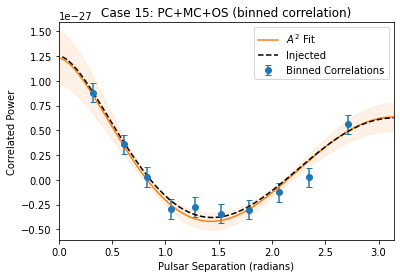

In [38]:
defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s,bins=10,orf=OS_obj.orf_names)

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.title('Case 15: PC+MC+OS (binned correlation)')
plt.grid()
plt.legend()
plt.show()

# Case 16: PC+NM+MC+OS
*See notes on Case 13 for details about the ``pcmc_orf`` flag*

In [39]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

A2,A2s,idx = OS_obj.compute_OS(N=100, pair_covariance=True, return_pair_vals=False)


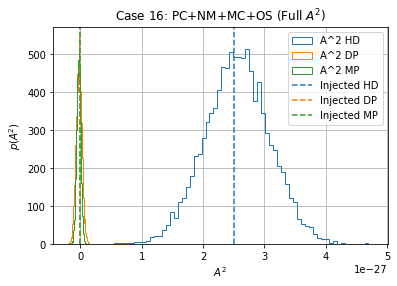

In [40]:
full_A2 = utils.uncertainty_sample(A2,A2s,pfos=False,mcos=True)
plt.hist(full_A2[:,0],bins='auto',histtype='step',color='C0',label='A^2 HD')
plt.hist(full_A2[:,1],bins='auto',histtype='step',color='C1',label='A^2 DP')
plt.hist(full_A2[:,2],bins='auto',histtype='step',color='C2',label='A^2 MP')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='C0',label='Injected HD')
plt.axvline(0,linestyle='dashed',color='C1',label='Injected DP')
plt.axvline(0,linestyle='dashed',color='C2',label='Injected MP')

plt.title('Case 16: PC+NM+MC+OS (Full $A^2$)')
plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Case 17: narrowband PF+MC+OS

In [41]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, narrowband=True)

fgw = OS_obj.freqs


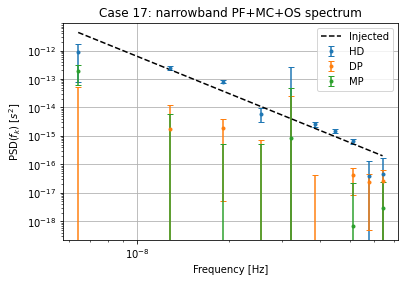

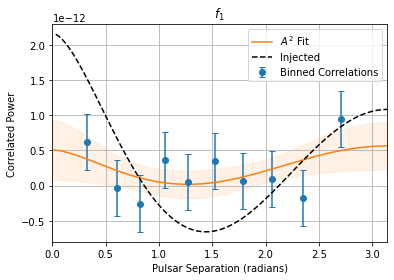

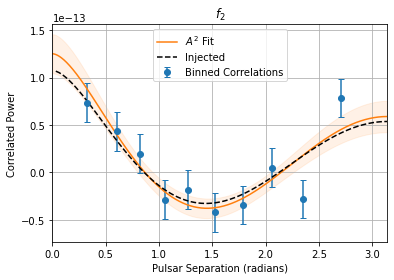

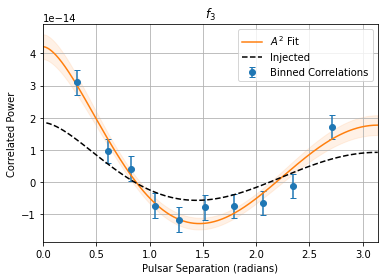

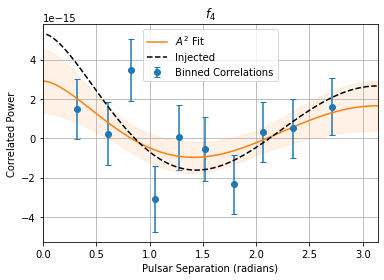

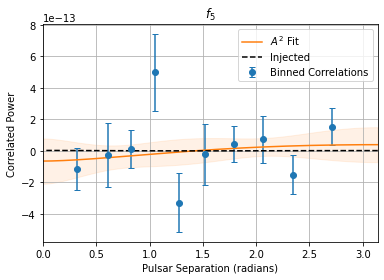

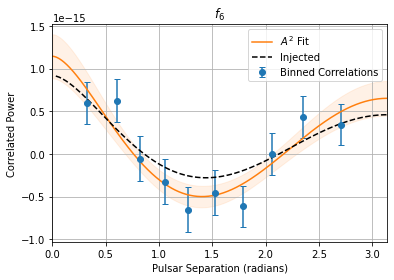

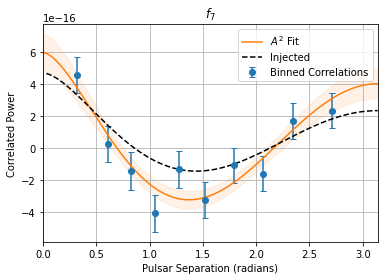

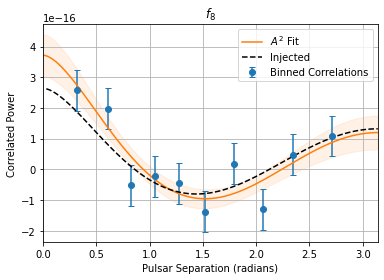

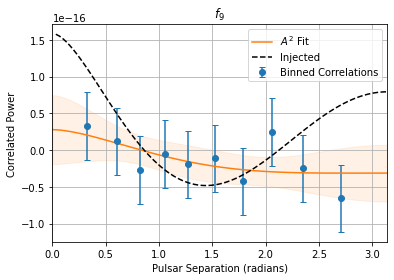

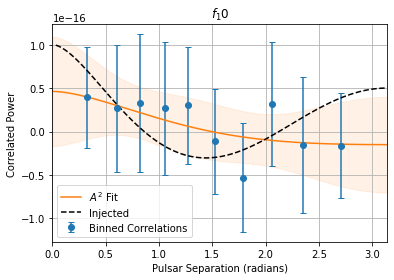

In [42]:
plt.errorbar(fgw,Sk[:,0],np.sqrt(Sks[:,0,0]),fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk[:,1],np.sqrt(Sks[:,1,1]),fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk[:,2],np.sqrt(Sks[:,2,2]),fmt='.',capsize=3,label='MP')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 17: narrowband PF+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10,
                                    orf=OS_obj.orf_names)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 18: narrowband PF+NM+MC+OS

In [43]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

Sk,Sks,idx = OS_obj.compute_PFOS(N=100, return_pair_vals=False, narrowband=True)

fgw = OS_obj.freqs


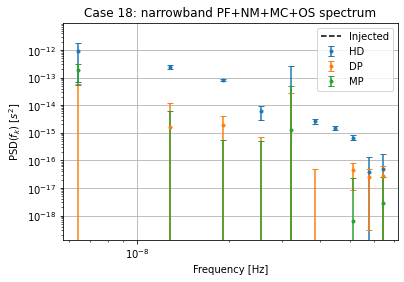

In [44]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=True)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean[:,0],Sk_std[:,0],fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk_mean[:,1],Sk_std[:,1],fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk_mean[:,2],Sk_std[:,2],fmt='.',capsize=3,label='MP')
plt.plot(np.log10(fgw),inj_spectrum,'--k',label='Injected')

plt.title('Case 18: narrowband PF+NM+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

# Case 19: narrowband PF+PC+MC+OS
*See notes on Case 13 for details about the ``pcmc_orf`` flag*

In [45]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, pair_covariance=True,
                                            narrowband=True)

fgw = OS_obj.freqs


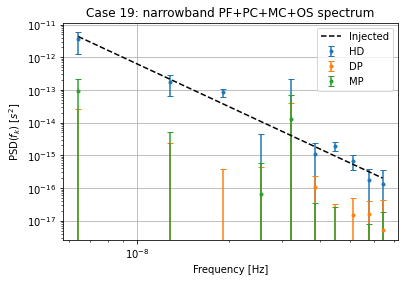

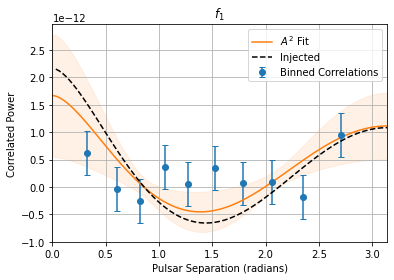

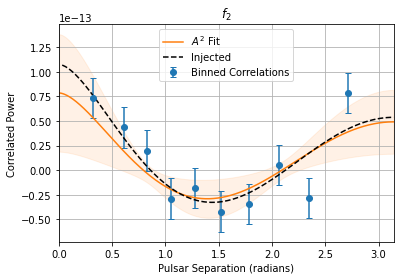

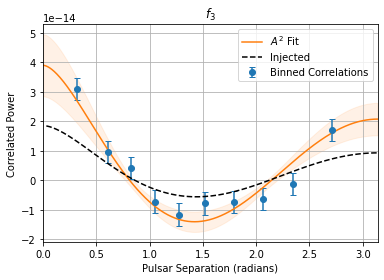

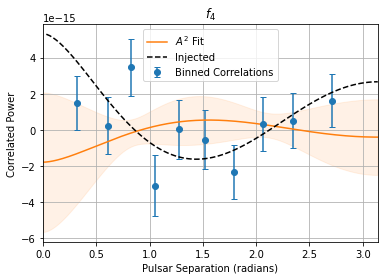

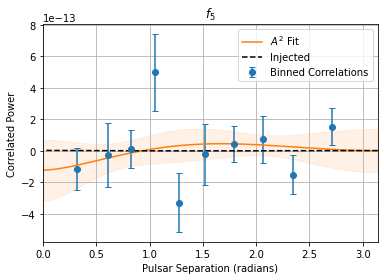

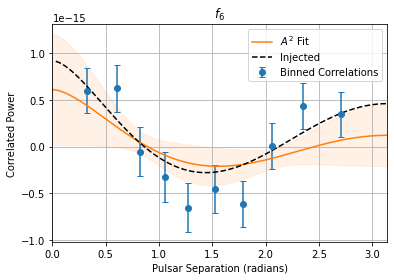

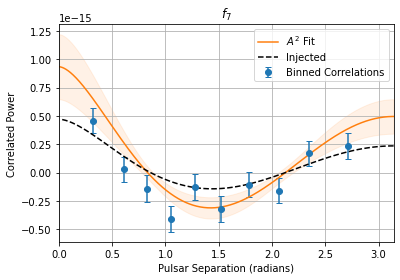

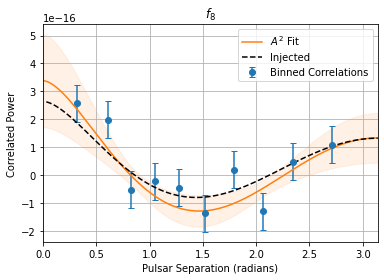

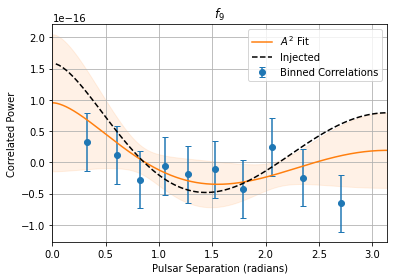

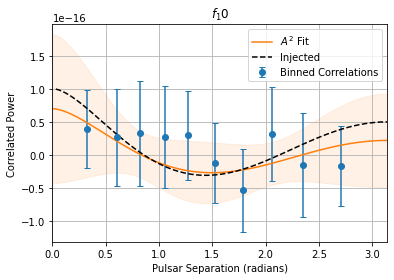

In [46]:
plt.errorbar(fgw,Sk[:,0],np.sqrt(Sks[:,0,0]),fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk[:,1],np.sqrt(Sks[:,1,1]),fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk[:,2],np.sqrt(Sks[:,2,2]),fmt='.',capsize=3,label='MP')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 19: narrowband PF+PC+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10,
                                    orf=OS_obj.orf_names)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 20: narrowband PF+PC+NM+MC+OS
*See notes on Case 13 for details about the ``pcmc_orf`` flag*

In [47]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False, narrowband=True)
fgw = OS_obj.freqs


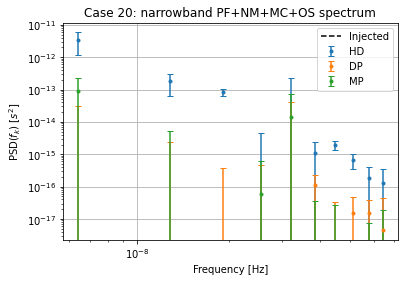

In [48]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=True)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean[:,0],Sk_std[:,0],fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk_mean[:,1],Sk_std[:,1],fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk_mean[:,2],Sk_std[:,2],fmt='.',capsize=3,label='MP')
plt.plot(np.log10(fgw),inj_spectrum,'--k',label='Injected')


plt.title('Case 20: narrowband PF+NM+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()


# Case 21: PF+MC+OS

In [49]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params)

fgw = OS_obj.freqs


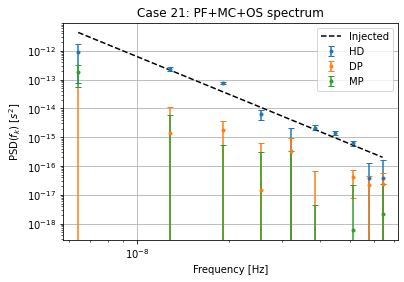

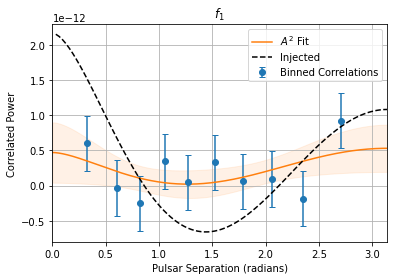

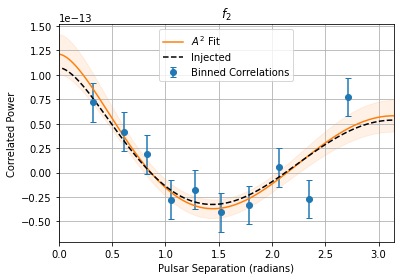

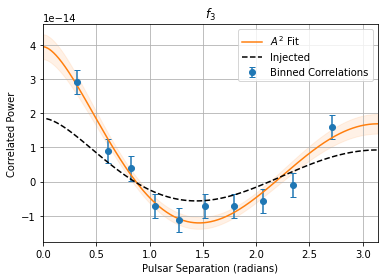

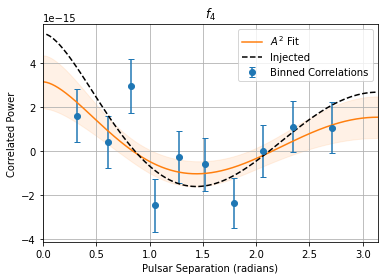

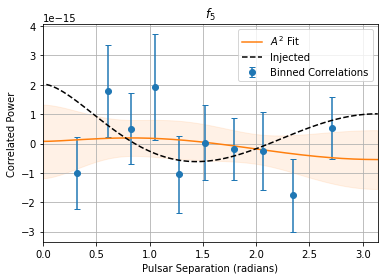

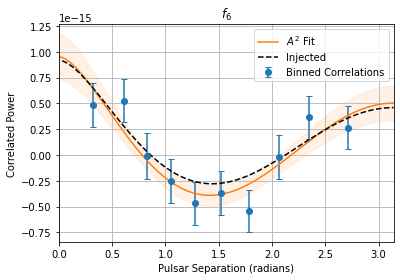

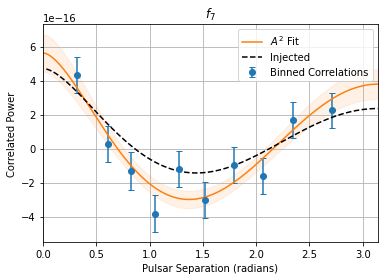

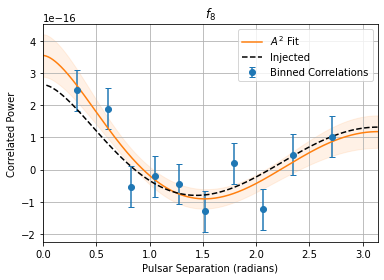

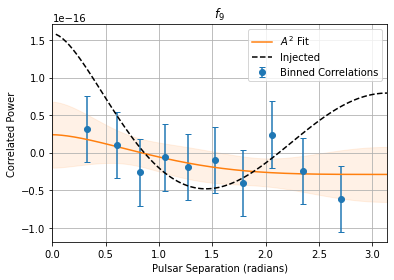

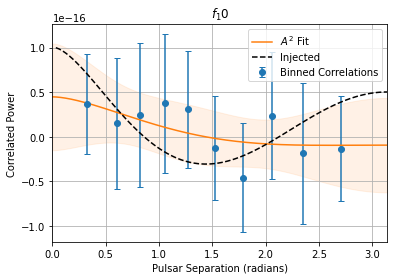

In [50]:
plt.errorbar(fgw,Sk[:,0],np.sqrt(Sks[:,0,0]),fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk[:,1],np.sqrt(Sks[:,1,1]),fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk[:,2],np.sqrt(Sks[:,2,2]),fmt='.',capsize=3,label='MP')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 21: PF+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10,
                                    orf=OS_obj.orf_names)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 22: PF+NM+MC+OS

In [51]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, return_pair_vals=False)

fgw = OS_obj.freqs

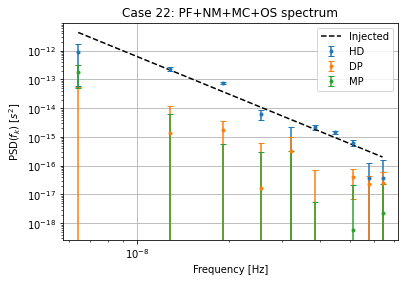

In [52]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=True)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean[:,0],Sk_std[:,0],fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk_mean[:,1],Sk_std[:,1],fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk_mean[:,2],Sk_std[:,2],fmt='.',capsize=3,label='MP')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 22: PF+NM+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()


# Case 23: PF+PC+MC+OS
*See notes on Case 13 for details about the ``pcmc_orf`` flag*

In [53]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, pair_covariance=True)

fgw = OS_obj.freqs

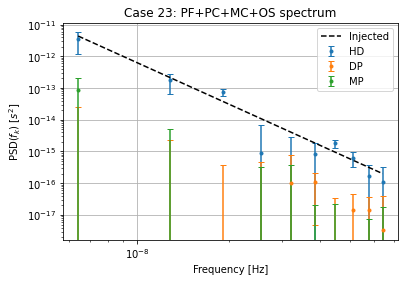

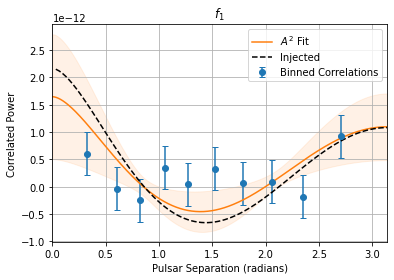

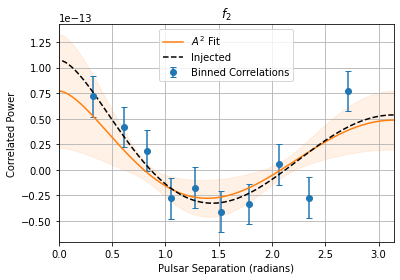

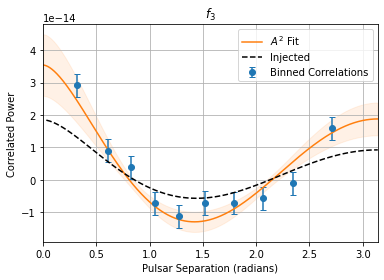

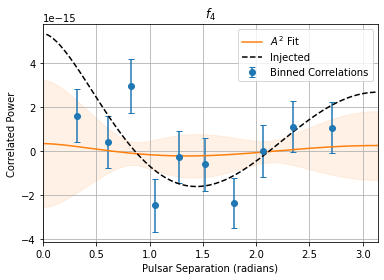

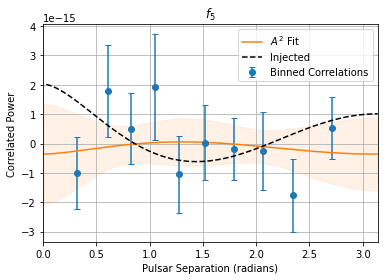

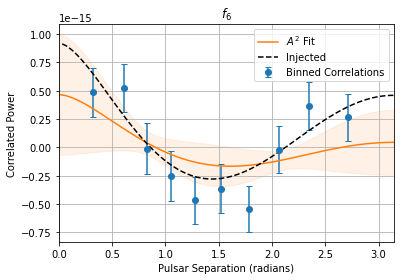

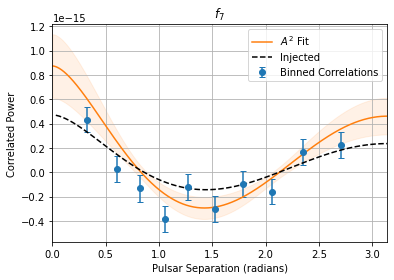

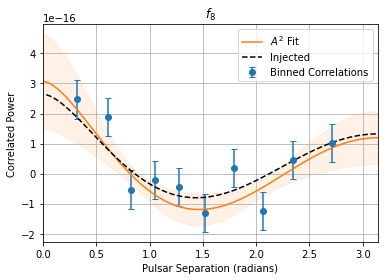

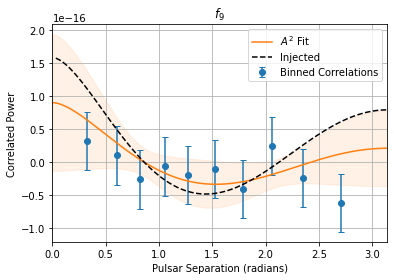

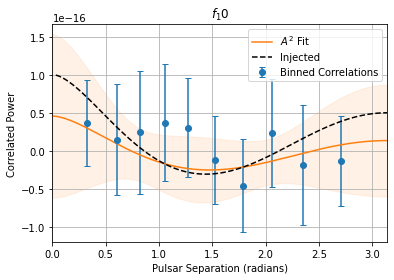

In [54]:

plt.errorbar(fgw,Sk[:,0],np.sqrt(Sks[:,0,0]),fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk[:,1],np.sqrt(Sks[:,1,1]),fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk[:,2],np.sqrt(Sks[:,2,2]),fmt='.',capsize=3,label='MP')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 23: PF+PC+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    defplot.create_correlation_plot(xi,rhok[k],sigk[k],Ck[k],Sk[k],Sks[k],bins=10,
                                    orf=OS_obj.orf_names)
    plt.plot(xi_range,inj_spectrum[k]*hd_mod,'--k',label='Injected')

    plt.title(f'$f_{k+1}$')
    plt.legend()
    plt.show()

# Case 24: PF+PC+NM+MC+OS
*See notes on Case 13 for details about the ``pcmc_orf`` flag*

In [55]:
OS_obj.set_orf(['hd','dipole','monopole'], pcmc_orf='hd')

Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False)

fgw = OS_obj.freqs

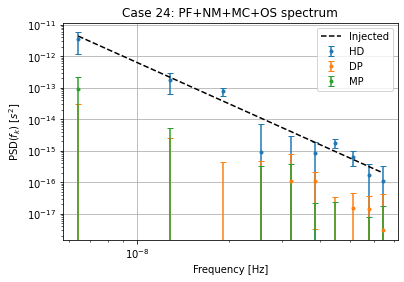

In [56]:
all_Sk = utils.uncertainty_sample(Sk,Sks,pfos=True,mcos=True)
Sk_mean, Sk_std = np.mean(all_Sk,axis=0), np.std(all_Sk,axis=0)

plt.errorbar(fgw,Sk_mean[:,0],Sk_std[:,0],fmt='.',capsize=3,label='HD')
plt.errorbar(fgw,Sk_mean[:,1],Sk_std[:,1],fmt='.',capsize=3,label='DP')
plt.errorbar(fgw,Sk_mean[:,2],Sk_std[:,2],fmt='.',capsize=3,label='MP')
plt.plot(fgw,inj_spectrum,'--k',label='Injected')

plt.title('Case 24: PF+NM+MC+OS spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.loglog()
plt.legend()
plt.grid()
plt.show()